<a href="https://colab.research.google.com/github/saadkiet/Transfer-Learning-Using-VGG-on-Food-Non-Food-image-dataset-Project-/blob/master/Transfer_Learning_Using_VGG_on_Food_Non_Food_image_dataset_(Project).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Step 1 : Set up and install

In [0]:
pip install tensorflow-gpu

     |████████████████████████████████| 421.8MB 25kB/s 
     |████████████████████████████████| 3.9MB 39.7MB/s 
     |████████████████████████████████| 450kB 39.2MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp36-none-any.whl size=7540 sha256=b04d9a75b21f5824347dd4c2935df93d0346d0e4cfd183b52f9bea6617f140b7
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
ERROR: tensorflow 2.2.0rc3 has requirement gast==0.3.3, but you'll have gast 0.2.2 which is incompatible.
ERROR: tensorflow 2.2.0rc3 has requirement tensorboard<2.3.0,>=2.2.0, but you'll have tensorboard 2.1.1 which is incompatible.
ERROR: tensorflow 2.2.0rc3 has requirement tensorflow-estimator<2.3.0,>=2.2.0rc0, but you'll have tensorflow-estimator 2.1.0 which is incompatible.
ERROR: tensorflow-probability 0.10.0rc0 has requirement gast>=0.3.2, but you'll have gast 0.2.2 which is incompatible.
  Found existing installation: gast 0.3.3
    Uninstall

In [0]:
import tensorflow as tf

In [0]:
# More imports
from tensorflow.keras.layers import Input, Dense, Flatten,Dropout
from tensorflow.keras.applications.vgg16 import VGG16 as PretrainedModel, preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from glob import glob

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys, os

# Step 2 : Importing Dataset

In [0]:
# Data from: https://mmspg.epfl.ch/downloads/food-image-datasets/
# !wget --passive-ftp --prefer-family=ipv4 --ftp-user FoodImage@grebvm2.epfl.ch \
#  --ftp-password Cahc1moo -nc ftp://tremplin.epfl.ch/Food-5K.zip
!wget -nc https://lazyprogrammer.me/course_files/Food-5K.zip

File ‘Food-5K.zip’ already there; not retrieving.



In [0]:
#Unzipping the file
!unzip /content/Food-5K.zip

Streaming output truncated to the last 5000 lines.
  inflating: Food-5K/training/1_188.jpg  
  inflating: Food-5K/training/1_822.jpg  
  inflating: Food-5K/training/0_1237.jpg  
  inflating: Food-5K/training/1_1223.jpg  
  inflating: Food-5K/training/1_1237.jpg  
  inflating: Food-5K/training/0_1223.jpg  
  inflating: Food-5K/training/1_349.jpg  
  inflating: Food-5K/training/1_70.jpg  
  inflating: Food-5K/training/1_64.jpg  
  inflating: Food-5K/training/0_628.jpg  
  inflating: Food-5K/training/0_166.jpg  
  inflating: Food-5K/training/1_375.jpg  
  inflating: Food-5K/training/1_413.jpg  
  inflating: Food-5K/training/0_600.jpg  
  inflating: Food-5K/training/1_407.jpg  
  inflating: Food-5K/training/0_614.jpg  
  inflating: Food-5K/training/1_58.jpg  
  inflating: Food-5K/training/0_172.jpg  
  inflating: Food-5K/training/1_361.jpg  
  inflating: Food-5K/training/0_199.jpg  
  inflating: Food-5K/training/0_1009.jpg  
  inflating: Food-5K/training/0_827.jpg  
  inflating: Food-5K/tr

In [0]:
!ls

In [0]:
!ls Food-5K

evaluation  training  validation


In [0]:
!ls /content/Food-5K/training

In [0]:
!mv Food-5K/* .

In [0]:
# look at an image for fun
plt.imshow(image.load_img('training/0_805.jpg'))
plt.show()

##Making new Directories

In [0]:
!mkdir data

In [0]:
!mkdir data/train
!mkdir data/test

In [0]:
!mkdir data/train/food
!mkdir data/train/nonfood

!mkdir data/test/food
!mkdir data/test/nonfood

Images starting with 1 are food images and images starting with 0 are non food images. So we will shift them in their respective folder

In [0]:
!mv training/0*.jpg data/train/nonfood
!mv training/1*.jpg data/train/food


In [0]:
!mv validation/0*.jpg data/test/nonfood
!mv validation/1*.jpg data/test/food

In [0]:
train_path = '/content/data/train'
valid_path = '/content/data/test'

In [0]:
# useful for getting number of files
image_files = glob(train_path + '/*/*.jpg')
valid_image_files = glob(valid_path + '/*/*.jpg')

In [0]:
# useful for getting number of classes
folders = glob(train_path + '/*')
folders

['/content/data/train/food', '/content/data/train/nonfood']

In [0]:
IMAGE_SIZE=[128,128]

# Step 3 : Loading VGG Model (BODY)

In [0]:
ptm = PretrainedModel(
    input_shape=IMAGE_SIZE + [3],
    weights='imagenet', 
    include_top=False)

In [0]:
ptm.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 32, 128)       0     

In [0]:
ptm.trainable=False

# Step 4 : Building ANN (HEAD)

In [0]:

x=Flatten()(ptm.output)
#x=Dropout(0.2)(x)
x=Dense(units=2,activation='softmax')(x)

model=Model(inputs=ptm.input,outputs=x)

In [0]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 32, 128)       0     

# Step 5 : Compiling Model

In [0]:
#opt=tf.keras.optimizers.Adam(learning_rate=0.05)

In [0]:
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

# Step 6 : Setting Image Data Generator

In [0]:
#Initializing Instances of Generator for Train and Test

gen_train=ImageDataGenerator(width_shift_range=0.1,
                             height_shift_range=0.1,
                             horizontal_flip=True,
                             preprocessing_function=preprocess_input,
                             #rotation_range=20,
                             #shear_range=0.1,
                             #zoom_range=0.2,
)

gen_test=ImageDataGenerator(preprocessing_function=preprocess_input)
                             

In [0]:
#Creating generators
batch_size=128

train_gen=gen_train.flow_from_directory(directory=train_path,target_size=IMAGE_SIZE,batch_size=batch_size,shuffle=True)

test_gen= gen_test.flow_from_directory(directory=valid_path,target_size=IMAGE_SIZE,batch_size=batch_size)

Found 3000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


# Step 7 : Training the Model

In [0]:
r=model.fit_generator(train_gen,
                      epochs=50,
                      validation_data=test_gen,
                      steps_per_epoch=int(np.ceil(len(image_files) / batch_size)),
                      validation_steps=int(np.ceil(len(valid_image_files) / batch_size)))

Epoch 1/50
24/24 [==============================] - 36s 1s/step - loss: 1.6934 - accuracy: 0.9087 - val_loss: 0.5922 - val_accuracy: 0.9690
Epoch 2/50
24/24 [==============================] - 36s 2s/step - loss: 0.5561 - accuracy: 0.9700 - val_loss: 0.5310 - val_accuracy: 0.9720
Epoch 3/50
24/24 [==============================] - 36s 2s/step - loss: 0.2919 - accuracy: 0.9810 - val_loss: 0.4579 - val_accuracy: 0.9760
Epoch 4/50
24/24 [==============================] - 36s 1s/step - loss: 0.2076 - accuracy: 0.9847 - val_loss: 0.6374 - val_accuracy: 0.9720
Epoch 5/50
24/24 [==============================] - 36s 1s/step - loss: 0.1880 - accuracy: 0.9860 - val_loss: 0.3640 - val_accuracy: 0.9780
Epoch 6/50
24/24 [==============================] - 36s 2s/step - loss: 0.1857 - accuracy: 0.9860 - val_loss: 0.7359 - val_accuracy: 0.9650
Epoch 7/50
24/24 [==============================] - 36s 1s/step - loss: 0.0998 - accuracy: 0.9927 - val_loss: 0.4609 - val_accuracy: 0.9740
Epoch 8/50
24/24 [==

# Step 8 : Model Evaluation

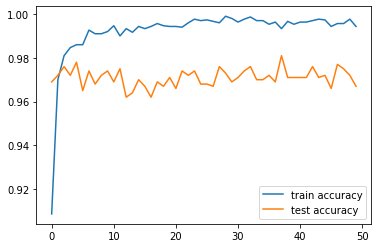

In [0]:
plt.plot(r.history['accuracy'],label='train accuracy')
plt.plot(r.history['val_accuracy'],label='test accuracy')
plt.legend()

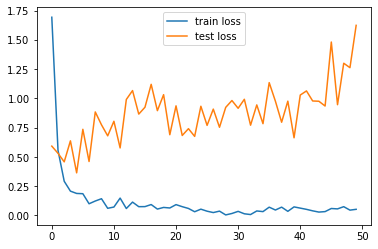

In [0]:
plt.plot(r.history['loss'],label='train loss')
plt.plot(r.history['val_loss'],label='test loss')
plt.legend()

# Changing model a bit

In [0]:
x1=Flatten()(ptm.output)
x1=Dropout(0.2)(x1)
x1=Dense(units=2,activation='softmax')(x1)

model1=Model(inputs=ptm.input,outputs=x1)

In [0]:
model1.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 32, 128)       0   

In [0]:
model1.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [0]:
r1=model1.fit_generator(train_gen,
                      epochs=20,
                      validation_data=test_gen,
                      steps_per_epoch=int(np.ceil(len(image_files) / batch_size)),
                      validation_steps=int(np.ceil(len(valid_image_files) / batch_size)))

Epoch 1/20
24/24 [==============================] - 36s 1s/step - loss: 1.8844 - accuracy: 0.9120 - val_loss: 0.7402 - val_accuracy: 0.9650
Epoch 2/20
24/24 [==============================] - 36s 1s/step - loss: 0.6759 - accuracy: 0.9677 - val_loss: 0.7247 - val_accuracy: 0.9720
Epoch 3/20
24/24 [==============================] - 36s 1s/step - loss: 0.4924 - accuracy: 0.9740 - val_loss: 0.6792 - val_accuracy: 0.9710
Epoch 4/20
24/24 [==============================] - 36s 1s/step - loss: 0.3627 - accuracy: 0.9800 - val_loss: 0.3489 - val_accuracy: 0.9790
Epoch 5/20
24/24 [==============================] - 36s 1s/step - loss: 0.3626 - accuracy: 0.9783 - val_loss: 0.9254 - val_accuracy: 0.9690
Epoch 6/20
24/24 [==============================] - 36s 1s/step - loss: 0.2153 - accuracy: 0.9833 - val_loss: 0.5909 - val_accuracy: 0.9780
Epoch 7/20
24/24 [==============================] - 36s 1s/step - loss: 0.1837 - accuracy: 0.9870 - val_loss: 0.8503 - val_accuracy: 0.9690
Epoch 8/20
24/24 [==

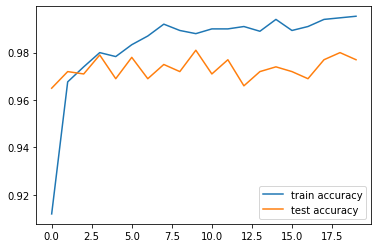

In [0]:
plt.plot(r1.history['accuracy'],label='train accuracy')
plt.plot(r1.history['val_accuracy'],label='test accuracy')
plt.legend()

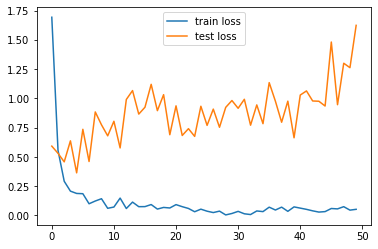

In [0]:
plt.plot(r.history['loss'],label='train loss')
plt.plot(r.history['val_loss'],label='test loss')
plt.legend()

In [0]:
x2=Flatten()(ptm.output)
x2=Dense(units=128,activation='relu')(x2)
x2=Dropout(0.2)(x2)
x2=Dense(units=2,activation='softmax')(x2)

model2=Model(inputs=ptm.input,outputs=x2)

In [0]:
model2.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 32, 128)       0   

In [0]:
model2.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [0]:
r2=model2.fit_generator(train_gen,
                      epochs=10,
                      validation_data=test_gen,
                      steps_per_epoch=int(np.ceil(len(image_files) / batch_size)),
                      validation_steps=int(np.ceil(len(valid_image_files) / batch_size)))

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 24 steps, validate for 8 steps
Epoch 1/10
24/24 [==============================] - 44s 2s/step - loss: 3.1294 - accuracy: 0.8950 - val_loss: 0.4372 - val_accuracy: 0.9590
Epoch 2/10
24/24 [==============================] - 36s 2s/step - loss: 0.1455 - accuracy: 0.9643 - val_loss: 0.1285 - val_accuracy: 0.9660
Epoch 3/10
24/24 [==============================] - 36s 2s/step - loss: 0.0735 - accuracy: 0.9717 - val_loss: 0.1260 - val_accuracy: 0.9650
Epoch 4/10
24/24 [==============================] - 36s 1s/step - loss: 0.0554 - accuracy: 0.9770 - val_loss: 0.1007 - val_accuracy: 0.9710
Epoch 5/10
24/24 [==============================] - 36s 2s/step - loss: 0.0352 - accuracy: 0.9887 - val_loss: 0.1107 - val_accuracy: 0.9740
Epoch 6/10
24/24 [==============================] - 36s 2s/step - loss: 0.0300 - accuracy: 0.9880 - val_loss: 0.1055 - val_accuracy: 

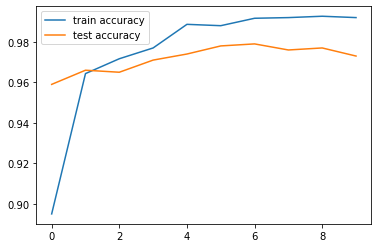

In [0]:
plt.plot(r2.history['accuracy'],label='train accuracy')
plt.plot(r2.history['val_accuracy'],label='test accuracy')
plt.legend()

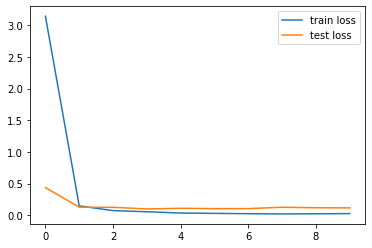

In [0]:
plt.plot(r2.history['loss'],label='train loss')
plt.plot(r2.history['val_loss'],label='test loss')
plt.legend()